<a href="https://colab.research.google.com/github/sajan-sarker/web-attack-detection/blob/main/code/web_attack_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
# importing dataset
df = pd.read_csv('/content/drive/MyDrive/web_attack_detection/payloads_dataset.csv')
print(df.shape)
print(f'Attack Types values:')
print(df['attack_type'].value_counts())

(46686, 4)
Attack Types values:
attack_type
norm              20895
sqli              10852
xss                7997
path-traversal     5838
cmdi               1104
Name: count, dtype: int64


In [10]:
# missing values count
missing_values = df.isnull().sum()
print(f"Missing Value List:")
print(missing_values)

Missing Value List:
payload        96
length          0
attack_type     0
label           0
dtype: int64


In [11]:
# Removing Duplicate values & missing values
df = df.drop_duplicates(subset=['payload'], keep=False)
df_attack_count = df['attack_type'].value_counts()
print(df_attack_count)
print(f'New shape: {df.shape}')

attack_type
norm              18279
sqli              10852
xss                7186
path-traversal     2227
cmdi                831
Name: count, dtype: int64
New shape: (39375, 4)


In [12]:
# label class count
df_lavel_counts = df['label'].value_counts()
print(df_lavel_counts)

label
anom    21096
norm    18279
Name: count, dtype: int64


In [13]:
# creating new features
df['char_count'] = df['payload'].apply(lambda x: sum(1 for c in x if c.isalpha()))
df['digit_count'] = df['payload'].apply(lambda x: sum(1 for c in x if c.isdigit()))
df['symbol_count'] = df['payload'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
df['special_count'] = df['payload'].apply(lambda x: sum(1 for c in x if not (c.isalnum() or c in string.punctuation)))

print(df.head())

            payload  length attack_type label  char_count  digit_count  \
0    c/ caridad s/n      14        norm  norm          10            0   
1      campello, el      12        norm  norm          10            0   
2             40184       5        norm  norm           0            5   
3  1442431887503330      16        norm  norm           0           16   
4             nue37       5        norm  norm           3            2   

   symbol_count  special_count  
0             2              2  
1             1              1  
2             0              0  
3             0              0  
4             0              0  


In [14]:
# Mapping categorical target columns
df['attack_type'] = df['attack_type'].map({'norm': 0, 'sqli': 1, 'xss': 2, 'cmdi': 3, 'path-traversal': 4})
df['label'] = df['label'].map({'norm': 0, 'anom': 1})

print(df.head())

            payload  length  attack_type  label  char_count  digit_count  \
0    c/ caridad s/n      14            0      0          10            0   
1      campello, el      12            0      0          10            0   
2             40184       5            0      0           0            5   
3  1442431887503330      16            0      0           0           16   
4             nue37       5            0      0           3            2   

   symbol_count  special_count  
0             2              2  
1             1              1  
2             0              0  
3             0              0  
4             0              0  


In [15]:
# summary statistics for numerical features
summary_stats = df[['length', 'char_count', 'digit_count', 'symbol_count', 'special_count']].describe()
print(summary_stats)

             length    char_count   digit_count  symbol_count  special_count
count  39375.000000  39375.000000  39375.000000  39375.000000    39375.00000
mean      49.330692     28.391365      8.149511      9.887822        2.90240
std       70.075887     53.585476     12.731077     19.003321        4.29018
min        1.000000      0.000000      0.000000      0.000000        0.00000
25%        9.000000      6.000000      0.000000      0.000000        0.00000
50%       30.000000     16.000000      2.000000      5.000000        1.00000
75%       63.000000     39.000000     12.000000     13.000000        4.00000
max     3061.000000   1672.000000    197.000000   1157.000000       85.00000


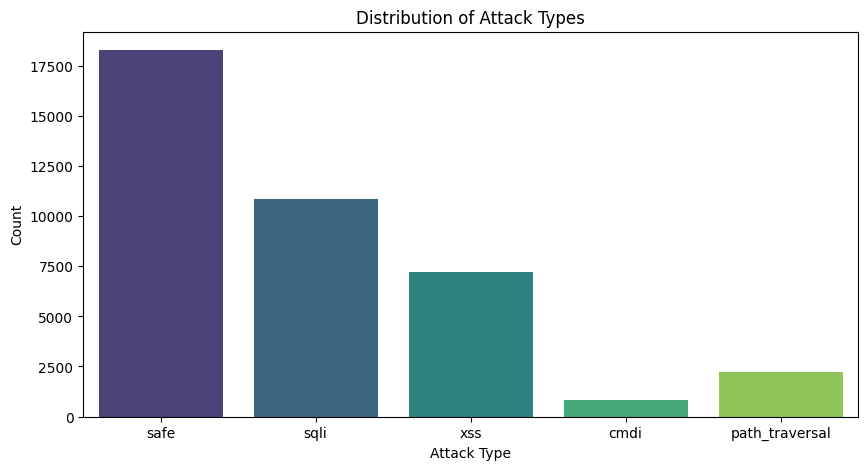

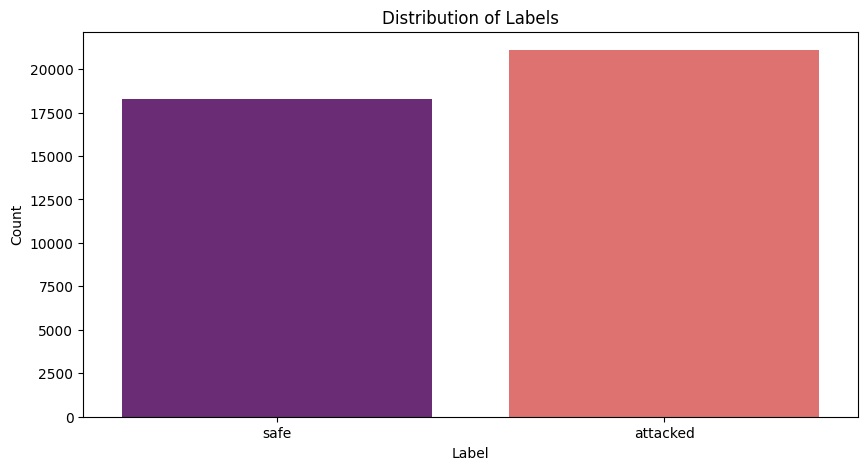

In [16]:
# Attack type distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='attack_type', palette='viridis')
plt.xticks([0, 1, 2, 3, 4], ['safe', 'sqli', 'xss', 'cmdi', 'path_traversal'])
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.show()

# Label distribution
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', palette='magma')
plt.xticks([0, 1], ['safe', 'attacked'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


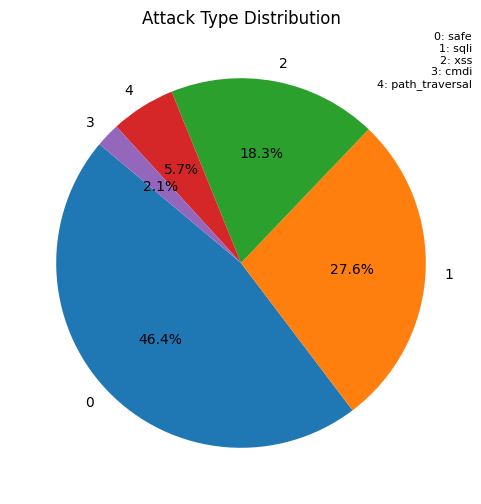

In [17]:
# pie chart for attack_type distribution
df['attack_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, figsize=(6, 6))
plt.title("Attack Type Distribution")
legend_text = "0: safe\n1: sqli\n2: xss\n3: cmdi\n4: path_traversal"
plt.text(1, 1, legend_text, ha='right', va='top', fontsize=8, transform=plt.gca().transAxes)
plt.ylabel('')
plt.show()

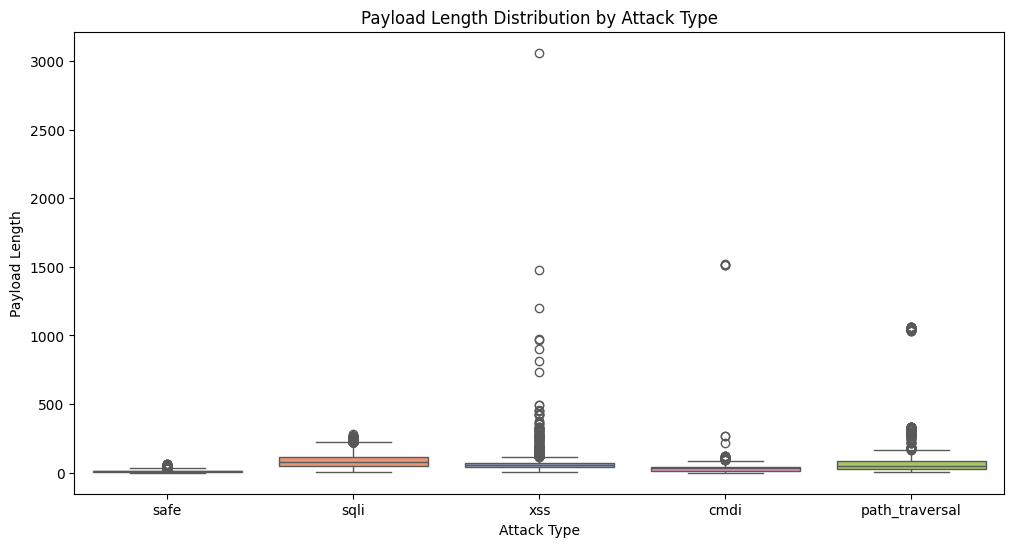

In [18]:
# each attack payloads length
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='attack_type', y='length', palette='Set2')
plt.xticks([0, 1, 2, 3, 4], ['safe', 'sqli', 'xss', 'cmdi', 'path_traversal'])
plt.title('Payload Length Distribution by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Payload Length')
plt.show()

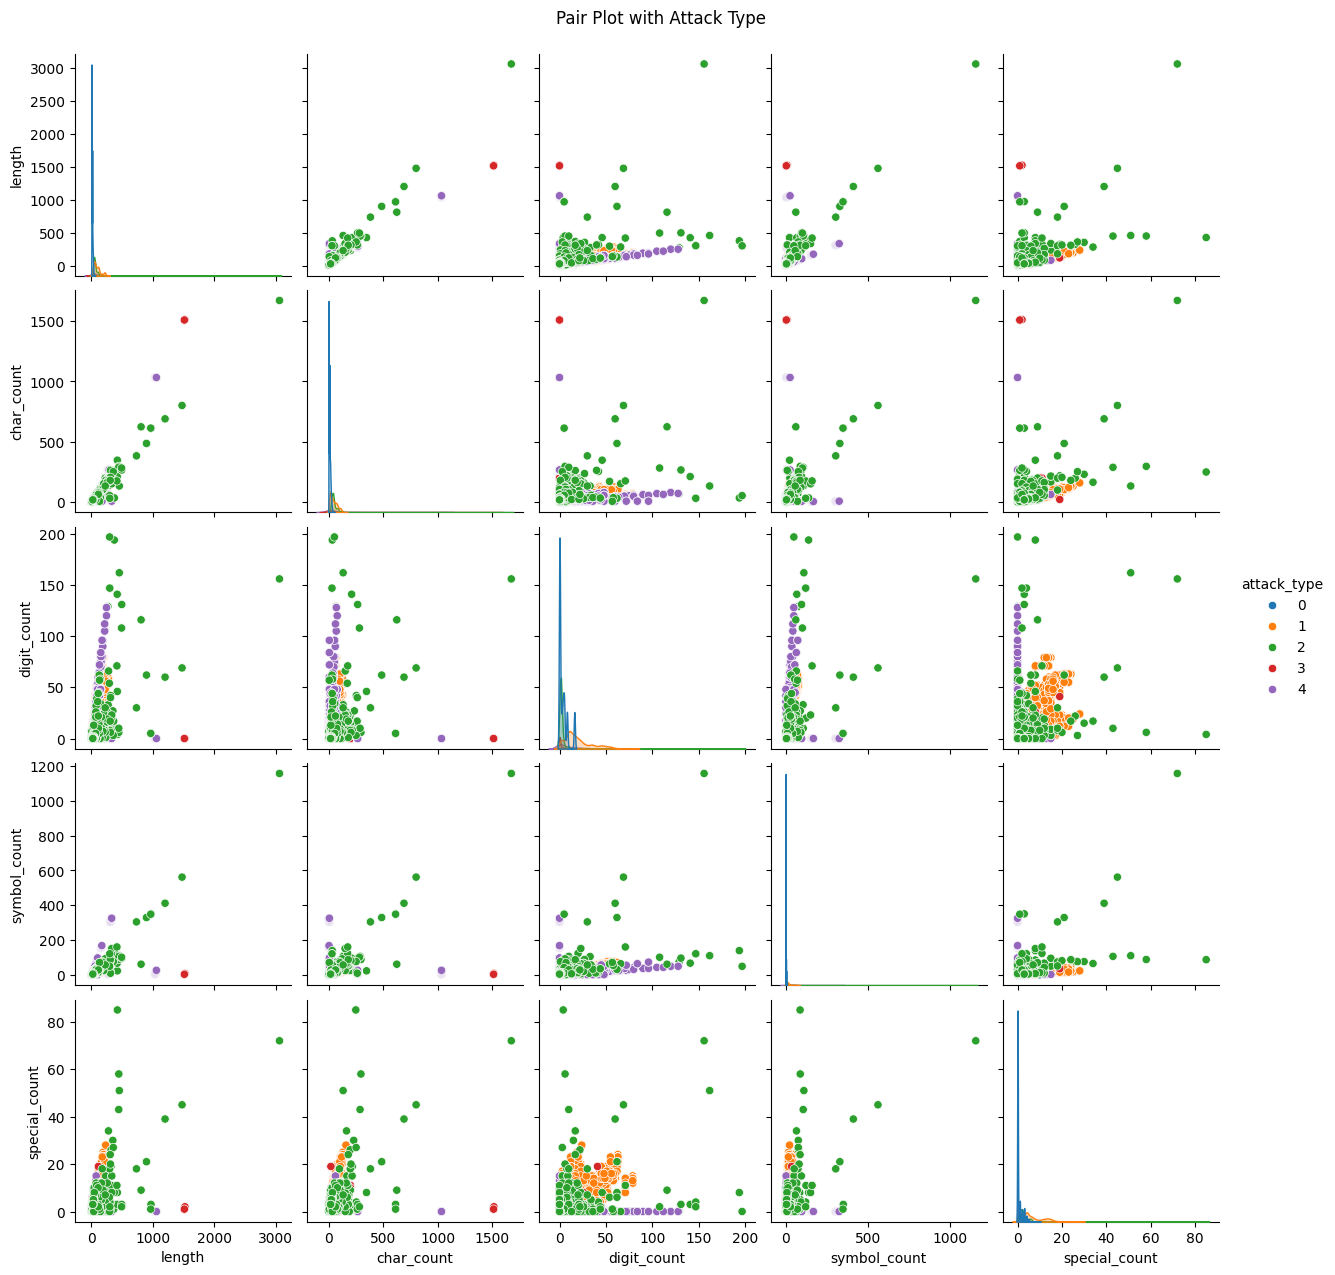

In [19]:
# pair plot with attack type
sns.pairplot(df[['length', 'char_count', 'digit_count', 'symbol_count', 'special_count', 'attack_type']], hue='attack_type', palette='tab10')
plt.suptitle('Pair Plot with Attack Type', y=1.02)
plt.show()

In [20]:
# apply TF-IDF Vectorization encoding on payload feature
df = shuffle(df, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
payload_tfidf = vectorizer.fit_transform(df['payload'])

In [21]:
additional_features = df[['length', 'char_count', 'digit_count', 'symbol_count', 'special_count']]
X = pd.concat([pd.DataFrame(payload_tfidf.toarray()), additional_features.reset_index(drop=True)], axis=1)
X.columns = X.columns.astype(str)

y = df[['attack_type', 'label']]

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (39375, 1005)
Shape of y: (39375, 2)


In [22]:
# train 70%, validation 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Write the train, validation, test datasets as CSV files
X_train.to_csv('/content/drive/MyDrive/web_attack_detection/X_train.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/web_attack_detection/y_train.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/web_attack_detection/X_val.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/web_attack_detection/y_val.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/web_attack_detection/X_test.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/web_attack_detection/y_test.csv', index=False)

In [4]:
# read the datasets
X_train = pd.read_csv('/content/drive/MyDrive/web_attack_detection/X_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/web_attack_detection/y_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/web_attack_detection/X_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/web_attack_detection/y_val.csv')
X_test = pd.read_csv('/content/drive/MyDrive/web_attack_detection/X_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/web_attack_detection/y_test.csv')
print(f'Train Data Shape (X, y): {X_train.shape, y_train.shape}')
print(f'Validation Data Shape (X, y): {X_val.shape, y_val.shape}')
print(f'Test Data Shape (X, y): {X_test.shape, y_test.shape}')

Train Data Shape (X, y): ((27562, 1005), (27562, 2))
Validation Data Shape (X, y): ((5906, 1005), (5906, 2))
Test Data Shape (X, y): ((5907, 1005), (5907, 2))


In [5]:
# combined training and validation set for later use
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

In [6]:
# confusion matrix display function to plot multiclass matrix horizontally.
def confusion_matrix_display(y_actual, y_pred):
  attack_cm = confusion_matrix(y_actual['attack_type'], y_pred[:, 0])
  label_cm = confusion_matrix(y_actual['label'], y_pred[:, 1])

  fig, axes = plt.subplots(1, 2, figsize=(15, 7))

  sns.heatmap(attack_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['norm', 'sqli', 'path_traversal', 'cmdi', 'xss'], yticklabels=['norm', 'sqli', 'path_traversal', 'cmdi', 'xss'], ax=axes[0])
  axes[0].set_title('Attack Type Confusion Matrix')
  axes[0].set_xlabel('Predicted Result')
  axes[0].set_ylabel('Actual Result')

  sns.heatmap(label_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['norm', 'anom'], yticklabels=['norm', 'anom'], ax=axes[1])
  axes[1].set_title('Label Confusion Matrix')
  axes[1].set_xlabel('Predicted Result')
  axes[1].set_ylabel('Actual Result')

  plt.tight_layout()
  plt.show()


*****
# Decision Tree Vs XGBoost Vs SVM Base Model

In [8]:
dt_base_model = DecisionTreeClassifier(random_state=42)
dt_base_model.fit(X_train, y_train)

y_test_base_pred_dt = dt_base_model.predict(X_test)

print("Test data report on Decision Tree:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_base_pred_dt[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_base_pred_dt[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_base_pred_dt[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_base_pred_dt[:, 1]))


xgb_base = XGBClassifier(random_state=42, eval_metric="logloss")
xgb_base_model = MultiOutputClassifier(xgb_base)
xgb_base_model.fit(X_train, y_train)

y_test_base_pred_xgb = xgb_base_model.predict(X_test)

print("Test data report on XGBoost:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_base_pred_xgb[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_base_pred_xgb[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_base_pred_xgb[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_base_pred_xgb[:, 1]))

svmc = SVC(random_state=42)
svm_base_model = MultiOutputClassifier(svmc)
svm_base_model.fit(X_train, y_train)

y_test_base_pred_svm = svm_base_model.predict(X_test)

print("Test data report on SVM:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_base_pred_svm[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_base_pred_svm[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_base_pred_svm[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_base_pred_svm[:, 1]))

Test data report on Decision Tree:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2766
           1       1.00      1.00      1.00      1610
           2       1.00      0.98      0.99      1065
           3       0.92      0.91      0.92       121
           4       0.98      1.00      0.99       345

    accuracy                           0.99      5907
   macro avg       0.98      0.98      0.98      5907
weighted avg       0.99      0.99      0.99      5907

Target: (label)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2766
           1       1.00      0.99      1.00      3141

    accuracy                           1.00      5907
   macro avg       1.00      1.00      1.00      5907
weighted avg       1.00      1.00      1.00      5907

Overall Accuracy on (attack_type): 0.9933976637887253
Overall Accuracy on (label): 0.9964448958862366
Test dat

*****
# Decision Tree Model vs XGBoost vs SVM Model

In [ ]:
# Decision Tree model
dt_param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# initialize DT model and gridsearchcv
dt = DecisionTreeClassifier(random_state=42)
dt_grid_search = GridSearchCV(estimator=dt, param_grid=dt_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

# best parameters from the grid search
print("Decision Tree Best Score:", dt_grid_search.best_score_)
print("Decision Tree Best Parameters:", dt_grid_search.best_params_)

Decision Tree Best Score: nan
Decision Tree Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# XGBoost model
xgb_param_grid = {
    'estimator__max_depth': [2, 4],
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.001, 0.01, 0.1],
}

# initialize XGBoost model and gridsearchcv
base_model = XGBClassifier(random_state=42, eval_metric="logloss")
xgb = MultiOutputClassifier(base_model)
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

# best parameters from the grid search
print("XGBoost Best Score:", xgb_grid_search.best_score_)
print("XGBoost Best Parameters:", xgb_grid_search.best_params_)

XGBoost Best Score: nan
XGBoost Best Parameters: {'estimator__learning_rate': 0.001, 'estimator__max_depth': 2, 'estimator__n_estimators': 100}


In [ ]:
# SVM model
svm_param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'poly'],
    'estimator__gamma': ['scale', 'auto'],
}

# initialize SVM model and gridsearchcv
svmc = SVC(random_state=42)
svm_model = MultiOutputClassifier(svmc)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

# best parameters from the grid search
print("SVM Best Score:", svm_grid_search.best_score_)
print("SVM Best Parameters:", svm_grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
SVM Best Score: nan
SVM Best Parameters: {'estimator__C': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'linear'}


*****
#Decision Tree model with best parameters

In [ ]:
# make a new decision tree model with best parameters and train it.
dt_best_params = dt_grid_search.best_params_
dt_best_model = DecisionTreeClassifier(random_state=42, **dt_best_params)
dt_best_model.fit(X_train, y_train)

Validation data report on Decision Tree:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2780
           1       0.97      1.00      0.98      1587
           2       1.00      0.97      0.98      1080
           3       0.96      0.67      0.79       131
           4       0.96      0.99      0.98       328

    accuracy                           0.98      5906
   macro avg       0.98      0.92      0.94      5906
weighted avg       0.98      0.98      0.98      5906

Target: (label)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2780
           1       0.99      0.99      0.99      3126

    accuracy                           0.99      5906
   macro avg       0.99      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906

Overall Accuracy on (attack_type): 0.9823907890281071
Overall Accuracy on (label): 0.9901794784964443
Co

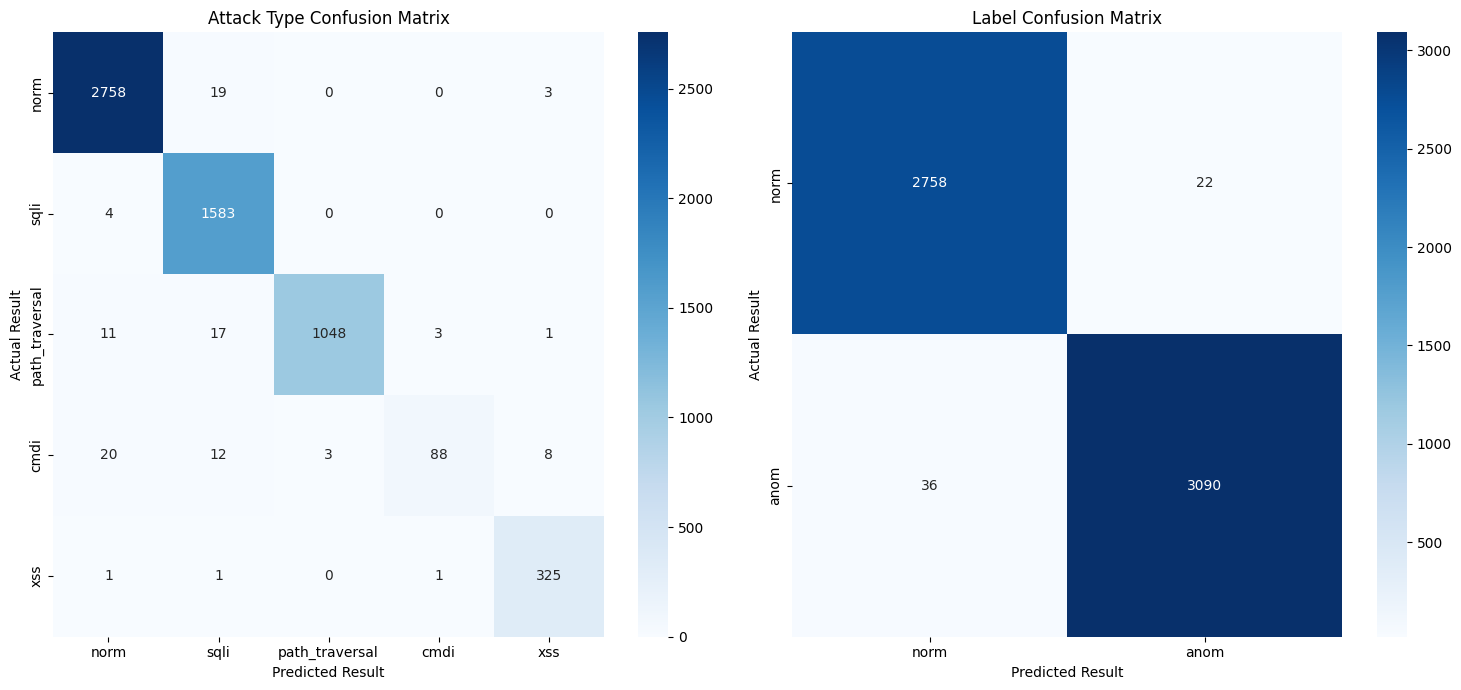

In [ ]:
y_val_pred_dt = dt_best_model.predict(X_val)

print("Validation data report on Decision Tree:\n")
print('Target: (attack_type)')
print(classification_report(y_val['attack_type'], y_val_pred_dt[:, 0]))

print('Target: (label)')
print(classification_report(y_val['label'], y_val_pred_dt[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_val['attack_type'], y_val_pred_dt[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_val['label'], y_val_pred_dt[:, 1]))

# confusion matrix on validation data
print("Confusion Matrix")
confusion_matrix_display(y_val, y_val_pred_dt)

In [ ]:
# retrain the decision tree model on combined training & validation dataset
dt_best_model.fit(X_train_val, y_train_val)
joblib.dump(dt_best_model, "/content/drive/MyDrive/web_attack_detection/decision_tree_wad.pkl")   # save the model

dt_model = joblib.load("/content/drive/MyDrive/web_attack_detection/decision_tree_wad.pkl") # load the model

Test data report on Decision Tree:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2766
           1       0.98      0.99      0.99      1610
           2       1.00      0.97      0.98      1065
           3       0.94      0.60      0.73       121
           4       0.94      0.99      0.96       345

    accuracy                           0.98      5907
   macro avg       0.97      0.91      0.93      5907
weighted avg       0.98      0.98      0.98      5907

Target: (label)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2766
           1       0.99      0.99      0.99      3141

    accuracy                           0.99      5907
   macro avg       0.99      0.99      0.99      5907
weighted avg       0.99      0.99      0.99      5907

Overall Accuracy on (attack_type): 0.9827323514474352
Overall Accuracy on (label): 0.9905197223632978
Confusio

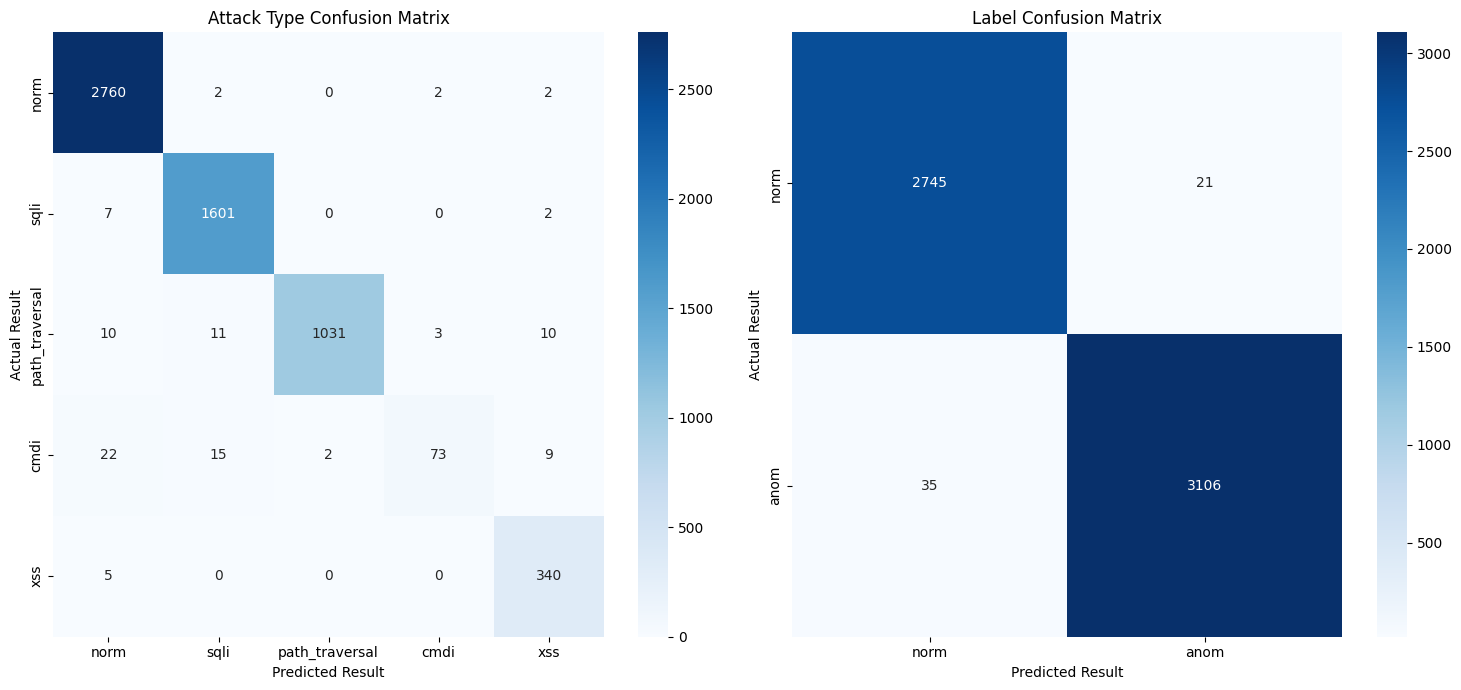

In [ ]:
y_test_pred_dt = dt_best_model.predict(X_test)

print("Test data report on Decision Tree:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_pred_dt[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_pred_dt[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_pred_dt[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_pred_dt[:, 1]))

# confusion matrix on validation data
print("Confusion Matrix")
confusion_matrix_display(y_test, y_test_pred_dt)

*****
# XGBoost Model with Best Parameters

In [ ]:
# make a new XGBoost model with best parameters and train it.
xgb_best_params = xgb_grid_search.best_params_
xgb_base_model = XGBClassifier(random_state=42, **xgb_best_params)
xgb_best_model = MultiOutputClassifier(xgb_base_model)
xgb_best_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              estimator__learning_rate=0.001,
                                              estimator__max_depth=2,
                                              estimator__n_estimators=100,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, ...))

In [ ]:
# retrain the decision tree model on combined training & validation dataset
xgb_best_model.fit(X_train_val, y_train_val)
joblib.dump(xgb_best_model, "/content/drive/MyDrive/web_attack_detection/xgboost_wad.pkl")   # save the model

xgb_model = joblib.load("/content/drive/MyDrive/web_attack_detection/xgboost_wad.pkl") # load the model

Validation data report on XGBoost:

Target: (attack_type)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2780
           1       1.00      1.00      1.00      1587
           2       0.99      0.99      0.99      1080
           3       0.95      0.89      0.92       131
           4       0.99      1.00      1.00       328

    accuracy                           1.00      5906
   macro avg       0.99      0.98      0.98      5906
weighted avg       1.00      1.00      1.00      5906

Target: (label)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2780
           1       1.00      1.00      1.00      3126

    accuracy                           1.00      5906
   macro avg       1.00      1.00      1.00      5906
weighted avg       1.00      1.00      1.00      5906

Overall Accuracy on (attack_type): 0.9954283779207586
Overall Accuracy on (label): 0.9971215712834406
Confusio

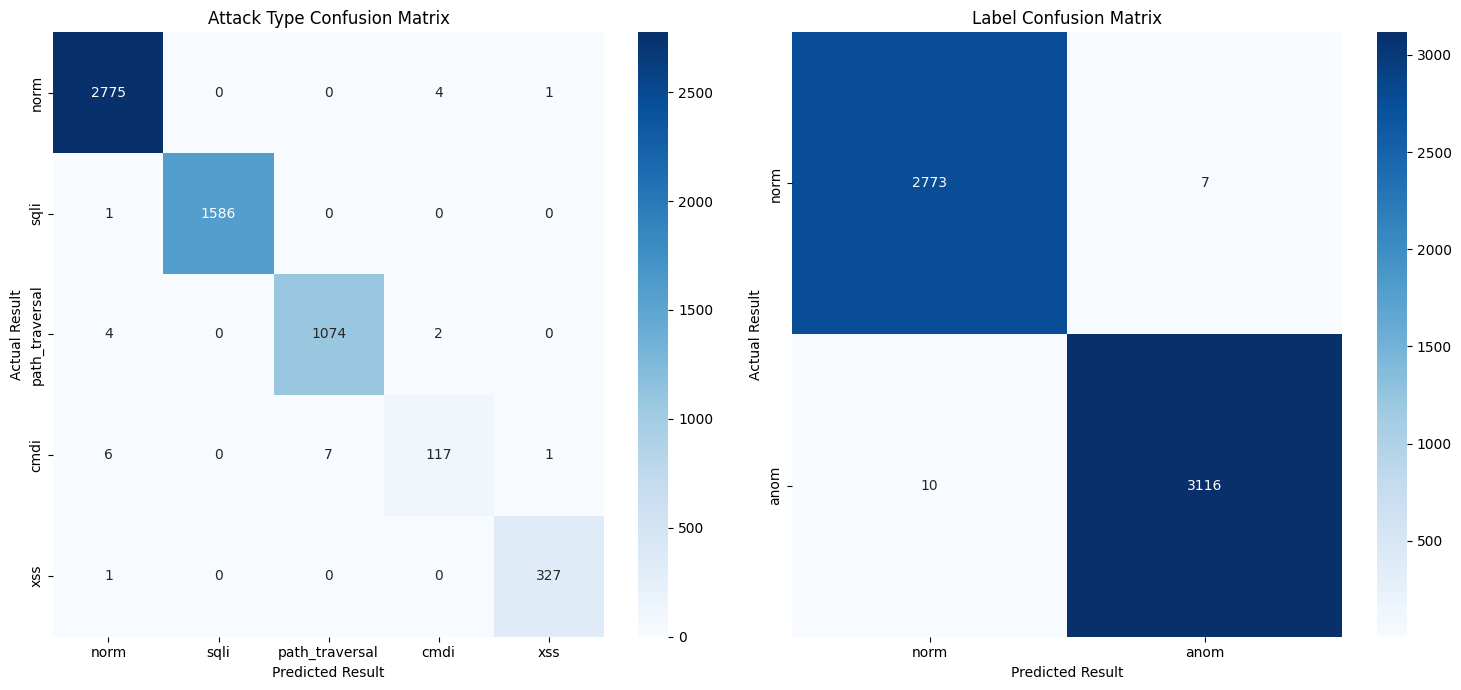

In [ ]:
y_val_pred_xgb = xgb_best_model.predict(X_val)

print("Validation data report on XGBoost:\n")
print('Target: (attack_type)')
print(classification_report(y_val['attack_type'], y_val_pred_xgb[:, 0]))

print('Target: (label)')
print(classification_report(y_val['label'], y_val_pred_xgb[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_val['attack_type'], y_val_pred_xgb[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_val['label'], y_val_pred_xgb[:, 1]))

# confusion matrix on validation data
print("Confusion Matrix")
confusion_matrix_display(y_val, y_val_pred_xgb)

Test data report on Decision Tree:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2766
           1       1.00      1.00      1.00      1610
           2       0.99      0.99      0.99      1065
           3       0.98      0.86      0.92       121
           4       1.00      1.00      1.00       345

    accuracy                           1.00      5907
   macro avg       0.99      0.97      0.98      5907
weighted avg       1.00      1.00      1.00      5907

Target: (label)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2766
           1       1.00      0.99      1.00      3141

    accuracy                           1.00      5907
   macro avg       1.00      1.00      1.00      5907
weighted avg       1.00      1.00      1.00      5907

Overall Accuracy on (attack_type): 0.9954291518537328
Overall Accuracy on (label): 0.9964448958862366
Confusio

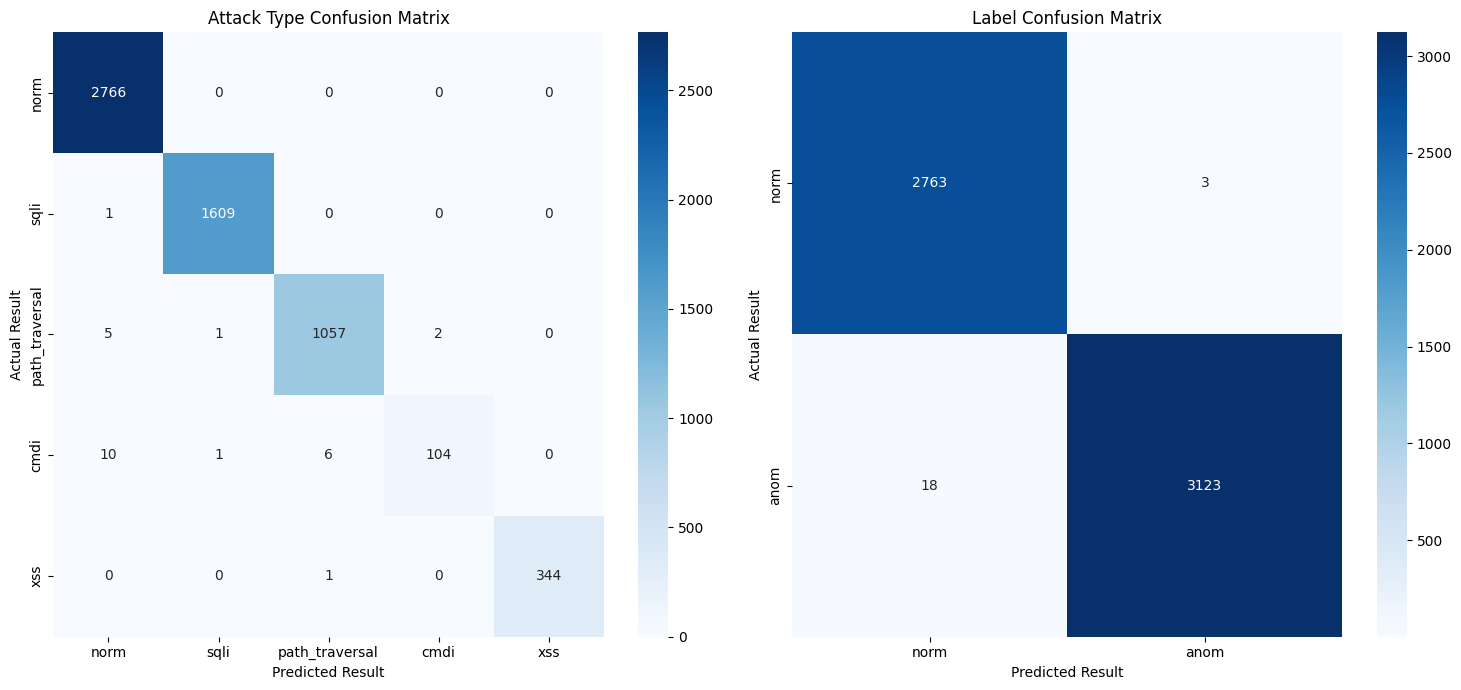

In [ ]:
y_test_pred_xgb = xgb_best_model.predict(X_test)

print("Test data report on Decision Tree:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_pred_xgb[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_pred_xgb[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_pred_xgb[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_pred_xgb[:, 1]))

# confusion matrix on validation data
print("Confusion Matrix")
confusion_matrix_display(y_test, y_test_pred_xgb)

*****
# SVM model with best parameters

In [ ]:
# make a new SVM model with best parameters and train it.
svm_best_params = svm_grid_search.best_params_
cleaned_svm_params = {key.replace('estimator__', ''): value for key, value in svm_best_params.items()}
svm_base_model = SVC(random_state=42, **cleaned_svm_params)
svm_best_model = MultiOutputClassifier(svm_base_model)
svm_best_model.fit(X_train, y_train)

MultiOutputClassifier(estimator=SVC(C=0.1, kernel='linear', random_state=42))

Validation data report on SVM:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2780
           1       1.00      1.00      1.00      1587
           2       0.99      0.98      0.99      1080
           3       0.97      0.72      0.82       131
           4       0.99      0.99      0.99       328

    accuracy                           0.99      5906
   macro avg       0.99      0.94      0.96      5906
weighted avg       0.99      0.99      0.99      5906

Target: (label)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2780
           1       1.00      0.99      0.99      3126

    accuracy                           0.99      5906
   macro avg       0.99      0.99      0.99      5906
weighted avg       0.99      0.99      0.99      5906

Overall Accuracy on (attack_type): 0.9889942431425669
Overall Accuracy on (label): 0.9925499492041991
Confusion Ma

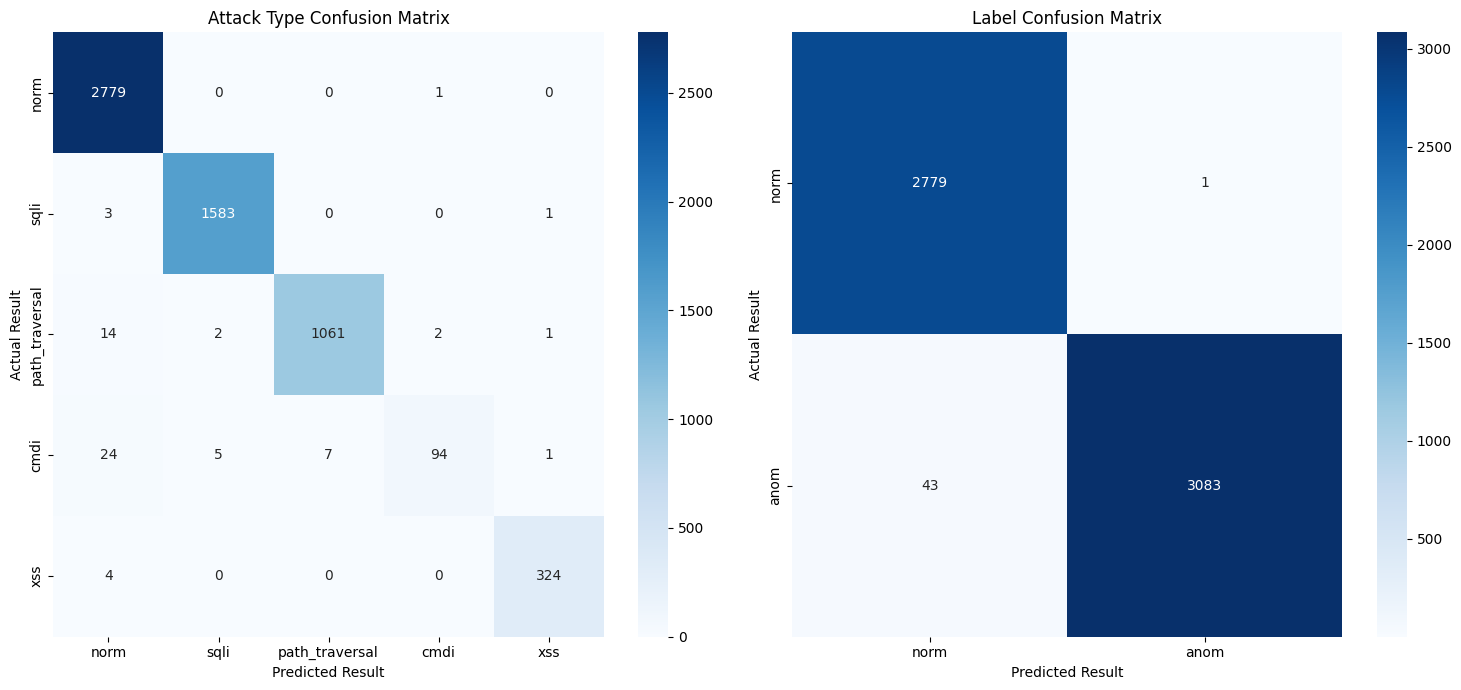

In [ ]:
y_val_pred_svm = svm_best_model.predict(X_val)

print("Validation data report on SVM:\n")
print('Target: (attack_type)')
print(classification_report(y_val['attack_type'], y_val_pred_svm[:, 0]))

print('Target: (label)')
print(classification_report(y_val['label'], y_val_pred_svm[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_val['attack_type'], y_val_pred_svm[:, 0]))

print("Overall Accuracy on (label):", accuracy_score(y_val['label'], y_val_pred_svm[:, 1]))


# confusion matrix on validation data
print("Confusion Matrix")
confusion_matrix_display(y_val, y_val_pred_svm)

In [ ]:
# retrain the decision tree model on combined training & validation dataset
svm_best_model.fit(X_train_val, y_train_val)
joblib.dump(svm_best_model, "/content/drive/MyDrive/web_attack_detection/svm_wad.pkl")   # save the model

svm_model = joblib.load("/content/drive/MyDrive/web_attack_detection/svm_wad.pkl") # load the model

Test data report on SVM:

Target: (attack_type)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2766
           1       1.00      1.00      1.00      1610
           2       1.00      0.99      0.99      1065
           3       0.99      0.75      0.85       121
           4       0.99      0.99      0.99       345

    accuracy                           0.99      5907
   macro avg       0.99      0.95      0.97      5907
weighted avg       0.99      0.99      0.99      5907

Target: (label)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2766
           1       1.00      0.99      0.99      3141

    accuracy                           0.99      5907
   macro avg       0.99      0.99      0.99      5907
weighted avg       0.99      0.99      0.99      5907

Overall Accuracy on (attack_type): 0.9917047570678855
Overall Accuracy on (label): 0.9940748264770611
Confusion Matrix


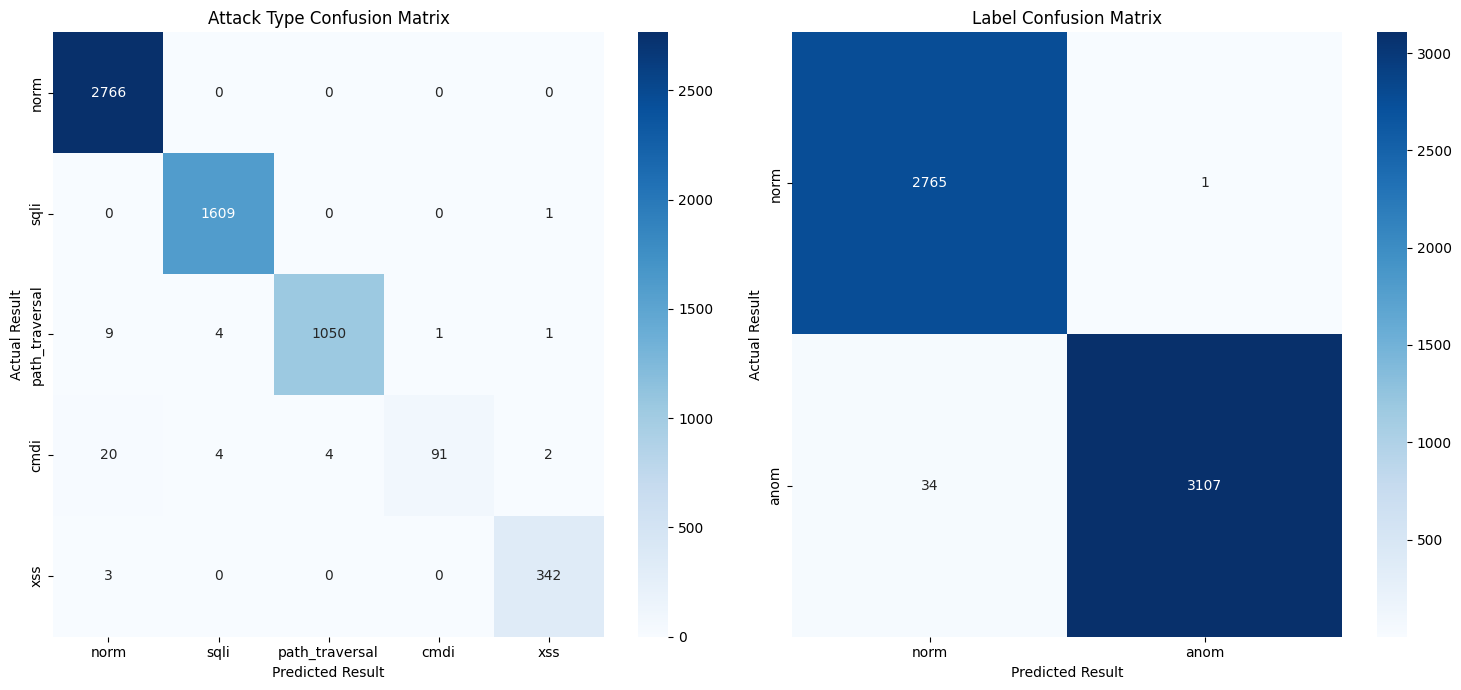

In [ ]:
y_test_pred_svm = svm_best_model.predict(X_test)

print("Test data report on SVM:\n")
print('Target: (attack_type)')
print(classification_report(y_test['attack_type'], y_test_pred_svm[:, 0]))

print('Target: (label)')
print(classification_report(y_test['label'], y_test_pred_svm[:, 1]))

print("Overall Accuracy on (attack_type):", accuracy_score(y_test['attack_type'], y_test_pred_svm[:, 0]))
print("Overall Accuracy on (label):", accuracy_score(y_test['label'], y_test_pred_svm[:, 1]))

# confusion matrix on test data
print("Confusion Matrix")
confusion_matrix_display(y_test, y_test_pred_svm)